In [2]:
import sys
import os
import dill
import json
import argparse
import torch
from torch import nn, optim, utils
import numpy as np
import pandas as pd

sys.path.append("../../trajectron")
from tqdm import tqdm
from model.model_registrar import ModelRegistrar
from model.trajectron import Trajectron
import evaluation

import time
import random
import pathlib
import warnings
from tqdm import tqdm
import visualization
import evaluation
import matplotlib.pyplot as plt
from model.trajectron import Trajectron
from model.model_registrar import ModelRegistrar
from model.model_utils import cyclical_lr
from model.dataset import EnvironmentDataset, collate
from tensorboardX import SummaryWriter

In [18]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [19]:
def load_model(model_dir, env, ts=100):
    model_registrar = ModelRegistrar(model_dir, 'cpu')
    model_registrar.load_models(ts)
    with open(os.path.join(model_dir, 'config.json'), 'r') as config_json:
        hyperparams = json.load(config_json)

    trajectron = Trajectron(model_registrar, hyperparams, None, 'cpu')
    trajectron.set_environment(env)
    trajectron.set_annealing_params()
    return trajectron, hyperparams


In [4]:
def plot_predictions(scene, predictions, timestep, ph, ax):
    """
    Piirtää ground truth + mallin ennusteet yhdelle agentille.
    """
    # Käydään läpi kaikki agentit (nodes)
    for node, node_preds in predictions.items():
        if timestep not in node_preds:
            continue

        # otetaan yksi sample
        sample = list(node_preds[timestep].values())[0]
        mean = sample['mean']  # shape: (ph, 2)

        # Ground truth (scene.future)
        gt = scene.future[node][timestep : timestep + ph]

        ax.plot(mean[:, 0], mean[:, 1], 'r-', label="Prediction", alpha=0.7)
        ax.plot(gt[:, 0], gt[:, 1], 'k--', label="Ground Truth", alpha=0.7)

    ax.legend()
    ax.set_title(f"Scene {scene.name}, t={timestep}")


In [5]:
print(os.listdir("../processed"))

['eth_val.pkl', 'univ_val.pkl', 'univ_train.pkl', 'nuScenes_train_mini_full.pkl', 'eth_test.pkl', 'zara1_val.pkl', 'zara2_val.pkl', 'zara2_test.pkl', 'zara2_train.pkl', 'eth_train.pkl', 'zara1_test.pkl', 'univ_test.pkl', 'hotel_test.pkl', 'hotel_val.pkl', 'nuScenes_test_mini_full.pkl', 'zara1_train.pkl', '.ipynb_checkpoints', 'hotel_train.pkl']


In [6]:

with open("../processed/eth_train.pkl", "rb") as f:
    env_train = dill.load(f)

with open("../processed/eth_val.pkl", "rb") as f:
    env_val = dill.load(f)

with open("../processed/eth_test.pkl", "rb") as f:
    env_test = dill.load(f)

print("Train scenes:", len(env_train.scenes))
print("Val scenes:", len(env_val.scenes))
print("Test scenes:", len(env_test.scenes))


Train scenes: 7
Val scenes: 7
Test scenes: 1


In [7]:
#polut
sys.path.append(os.getcwd())


model_dir = "models/models_11_Jul_2025_14_20_29_eth_vel_ar3"      # missä model_registrar ja config.json
checkpoint = 100              # esim. viimeinen epoch-numero
test_data_path = "../processed/eth_test.pkl"

In [21]:
print(os.listdir("models/models_11_Jul_2025_14_20_29_eth_vel_ar3"))

['model_registrar-17.pt', 'model_registrar-41.pt', 'model_registrar-31.pt', 'model_registrar-25.pt', 'events.out.tfevents.1752232829.dgx1.int.triton.aalto.fi', 'model_registrar-5.pt', 'model_registrar-66.pt', 'model_registrar-1.pt', 'model_registrar-26.pt', 'model_registrar-69.pt', 'model_registrar-50.pt', 'model_registrar-30.pt', 'model_registrar-20.pt', 'model_registrar-86.pt', 'model_registrar-54.pt', 'model_registrar-90.pt', 'model_registrar-4.pt', 'model_registrar-42.pt', 'model_registrar-28.pt', 'config.json', 'model_registrar-27.pt', 'model_registrar-72.pt', 'model_registrar-81.pt', 'model_registrar-3.pt', 'model_registrar-49.pt', 'model_registrar-48.pt', 'model_registrar-58.pt', 'model_registrar-59.pt', 'model_registrar-88.pt', 'model_registrar-97.pt', 'model_registrar-74.pt', 'model_registrar-52.pt', 'model_registrar-98.pt', 'model_registrar-45.pt', 'model_registrar-14.pt', 'model_registrar-78.pt', 'model_registrar-84.pt', 'model_registrar-71.pt', 'model_registrar-11.pt', 'mod

In [22]:
with open(test_data_path, "rb") as f:
    env = dill.load(f, encoding="latin1")


In [23]:
#mallin lataus
model, hyp = load_model(model_dir, env, ts=checkpoint)


Loading from models/models_11_Jul_2025_14_20_29_eth_vel_ar3/model_registrar-100.pt
Loaded!



In [24]:
print(hyp)

{'batch_size': 256, 'grad_clip': 1.0, 'learning_rate_style': 'exp', 'learning_rate': 0.001, 'min_learning_rate': 1e-05, 'learning_decay_rate': 0.9999, 'prediction_horizon': 12, 'minimum_history_length': 1, 'maximum_history_length': 7, 'map_encoder': {'PEDESTRIAN': {'heading_state_index': 6, 'patch_size': [50, 10, 50, 90], 'map_channels': 3, 'hidden_channels': [10, 20, 10, 1], 'output_size': 32, 'masks': [5, 5, 5, 5], 'strides': [1, 1, 1, 1], 'dropout': 0.5}}, 'k': 1, 'k_eval': 25, 'kl_min': 0.07, 'kl_weight': 100.0, 'kl_weight_start': 0, 'kl_decay_rate': 0.99995, 'kl_crossover': 400, 'kl_sigmoid_divisor': 4, 'rnn_kwargs': {'dropout_keep_prob': 0.75}, 'MLP_dropout_keep_prob': 0.9, 'enc_rnn_dim_edge': 32, 'enc_rnn_dim_edge_influence': 32, 'enc_rnn_dim_history': 32, 'enc_rnn_dim_future': 32, 'dec_rnn_dim': 128, 'q_z_xy_MLP_dims': None, 'p_z_x_MLP_dims': 32, 'GMM_components': 1, 'log_p_yt_xz_max': 6, 'N': 1, 'K': 25, 'tau_init': 2.0, 'tau_final': 0.05, 'tau_decay_rate': 0.997, 'use_z_logit

In [25]:
print(hyp['prediction_horizon'])

12


In [26]:
print(hyp['maximum_history_length'])

7


In [27]:
print(model)

In [28]:
# scenes
scenes = env.scenes

In [29]:
# parametrit
ph = hyp['prediction_horizon']

In [33]:
max_hl = hyp['maximum_history_length']


In [34]:
if not torch.cuda.is_available():
    device = torch.device('cpu')
else:
    if torch.cuda.device_count() == 1:
        # If you have CUDA_VISIBLE_DEVICES set, which you should,
        # then this will prevent leftover flag arguments from
        # messing with the device allocation.
        device = 'cuda:0'

In [35]:
model_registrar = ModelRegistrar(model_dir, device)


In [36]:
log_writer = None

In [37]:
trajectron = Trajectron(model_registrar,
                        hyp,
                        log_writer,
                        device)
trajectron.set_environment(env)
trajectron.set_annealing_params()

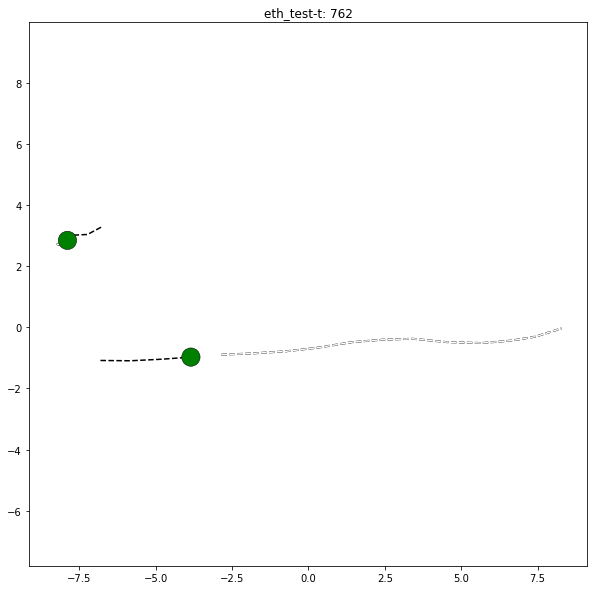

In [102]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


AttributeError: 'NoneType' object has no attribute 'add_figure'

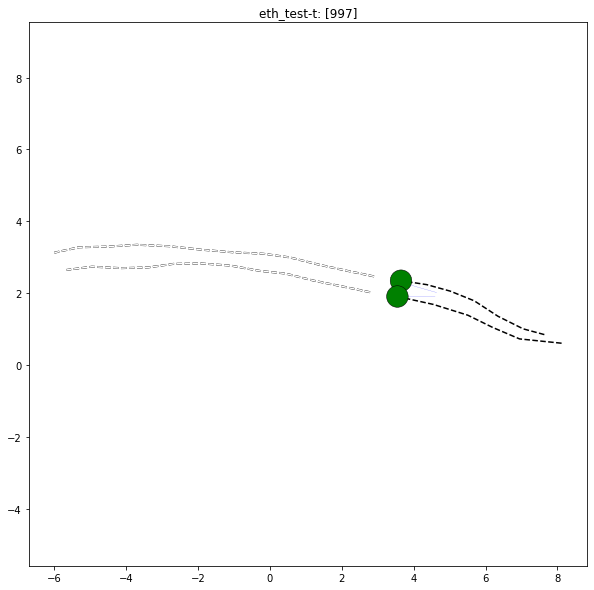

In [98]:
with torch.no_grad(): #estää gradienttien laskemisen
    scene = np.random.choice(scenes)

    timestep = scene.sample_timesteps(1, min_future_timesteps=ph)
    predictions = trajectron.predict(scene,
                                     timestep,
                                     ph,
                                     min_future_timesteps=ph,
                                     z_mode=True,
                                     gmm_mode=True,
                                     all_z_sep=False,
                                     full_dist=False)

    # Plot predicted timestep for random scene
    fig, ax = plt.subplots(figsize=(10, 10))
    visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
    ax.set_title(f"{scene.name}-t: {timestep}")
    log_writer.add_figure('train/prediction', fig, epoch) #tallennus tensorboardiin

    model_registrar.to(args.eval_device)

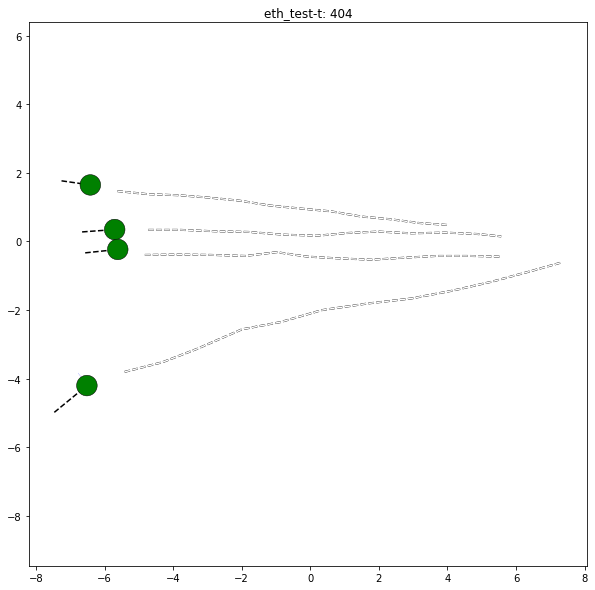

In [103]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


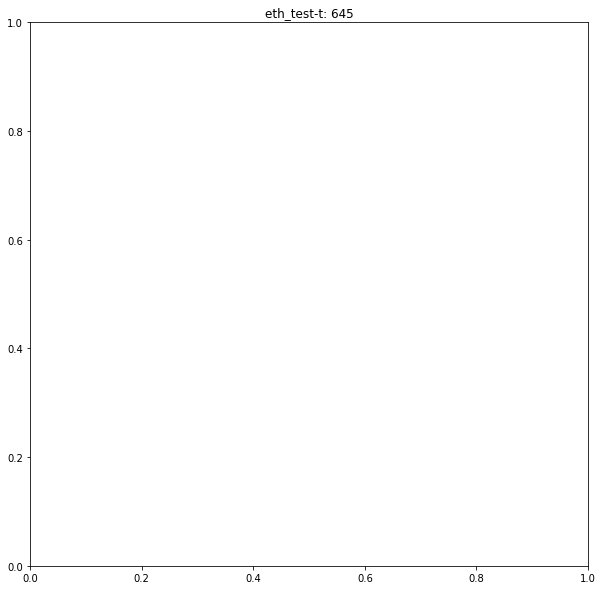

In [104]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


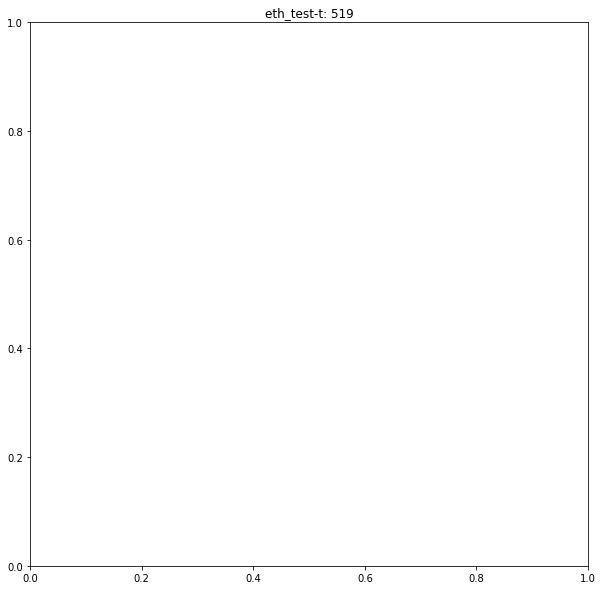

In [105]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


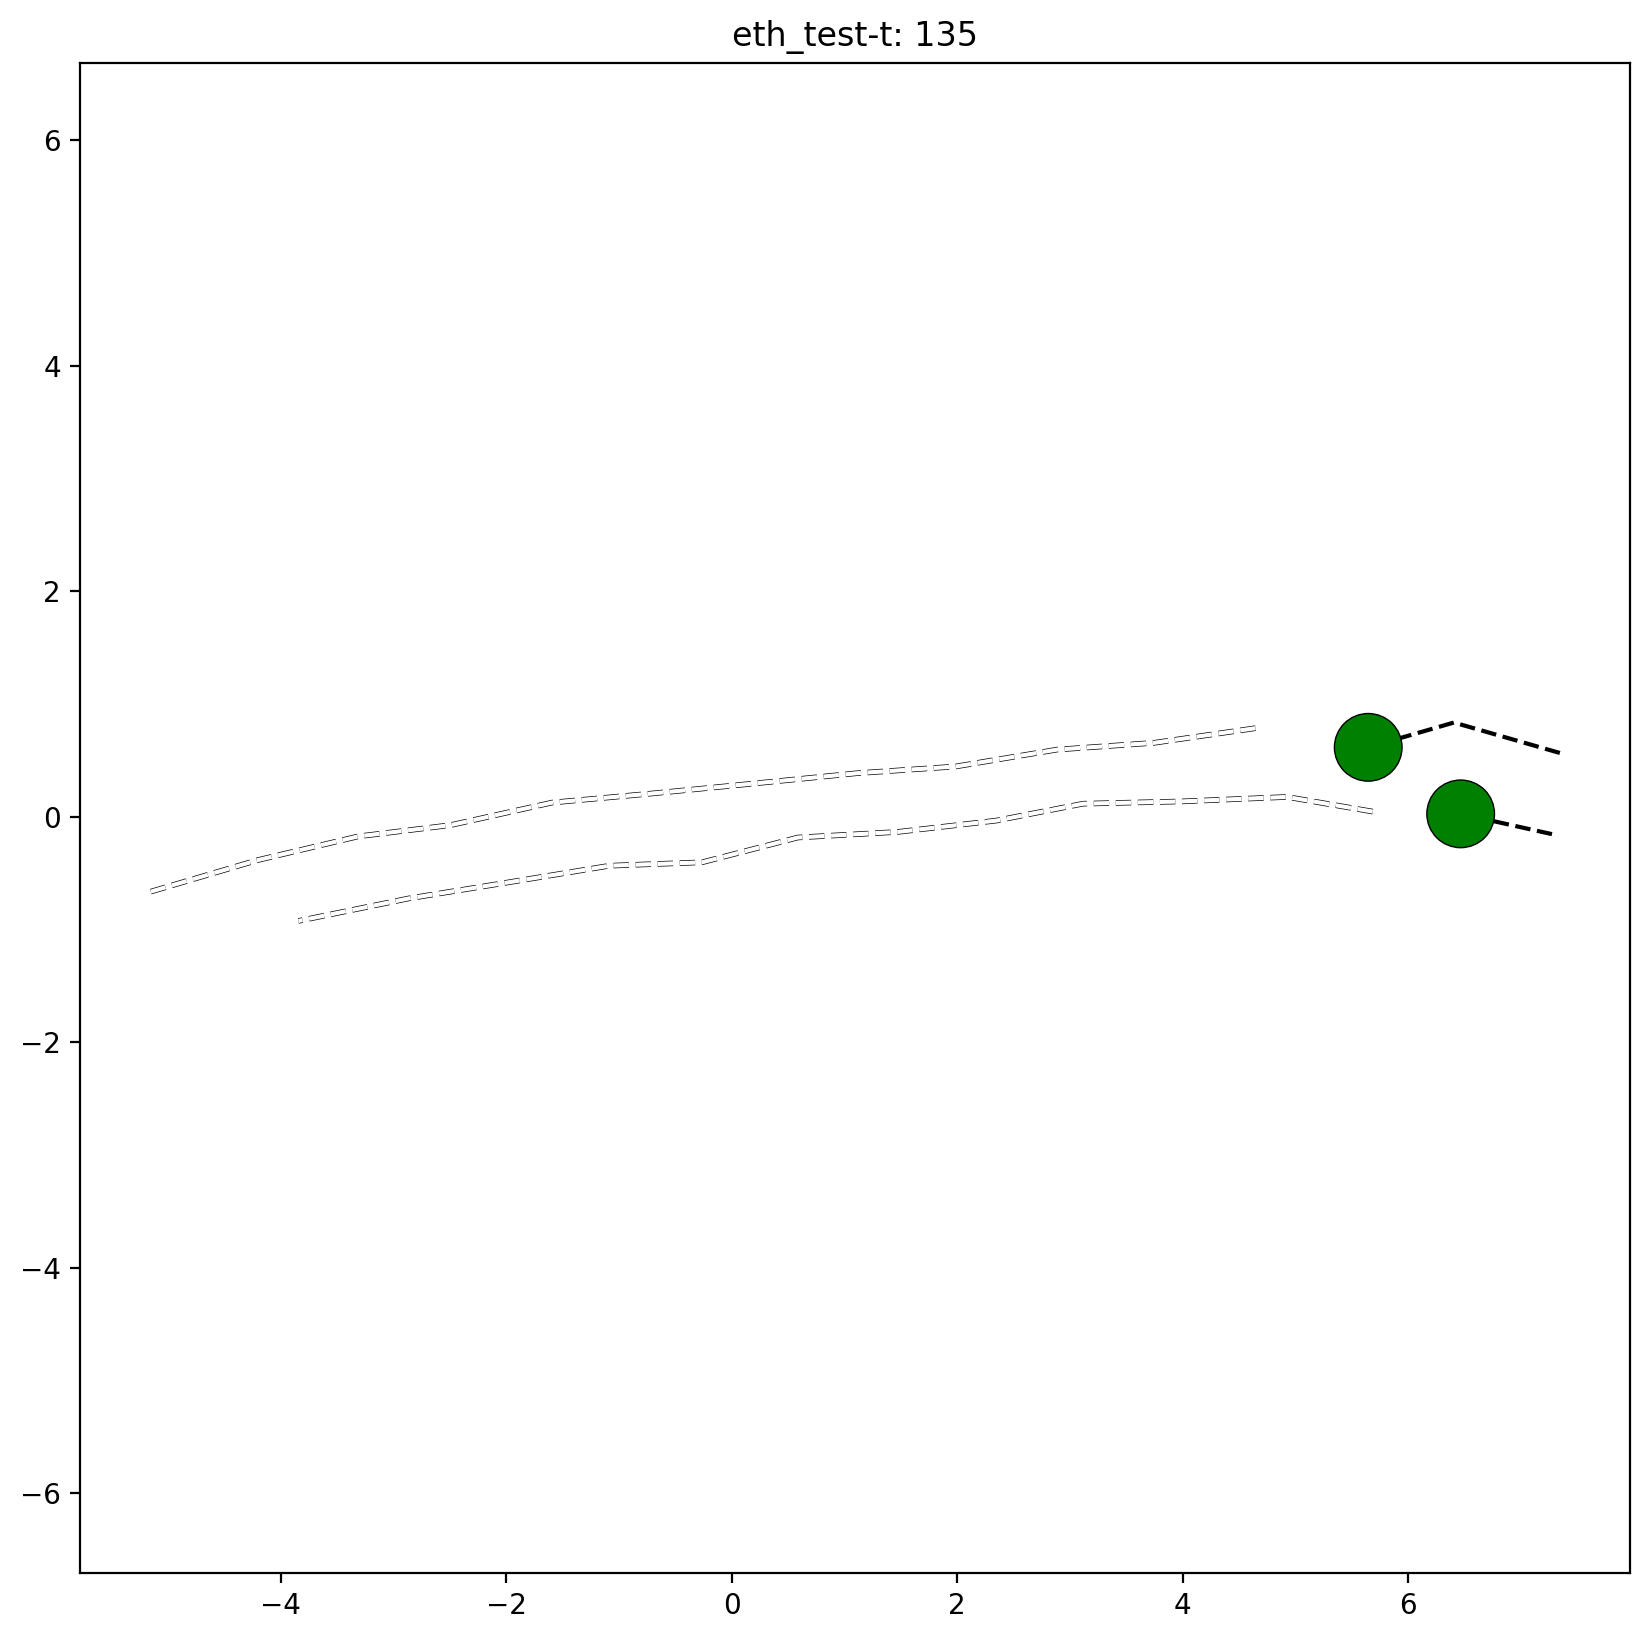

In [106]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


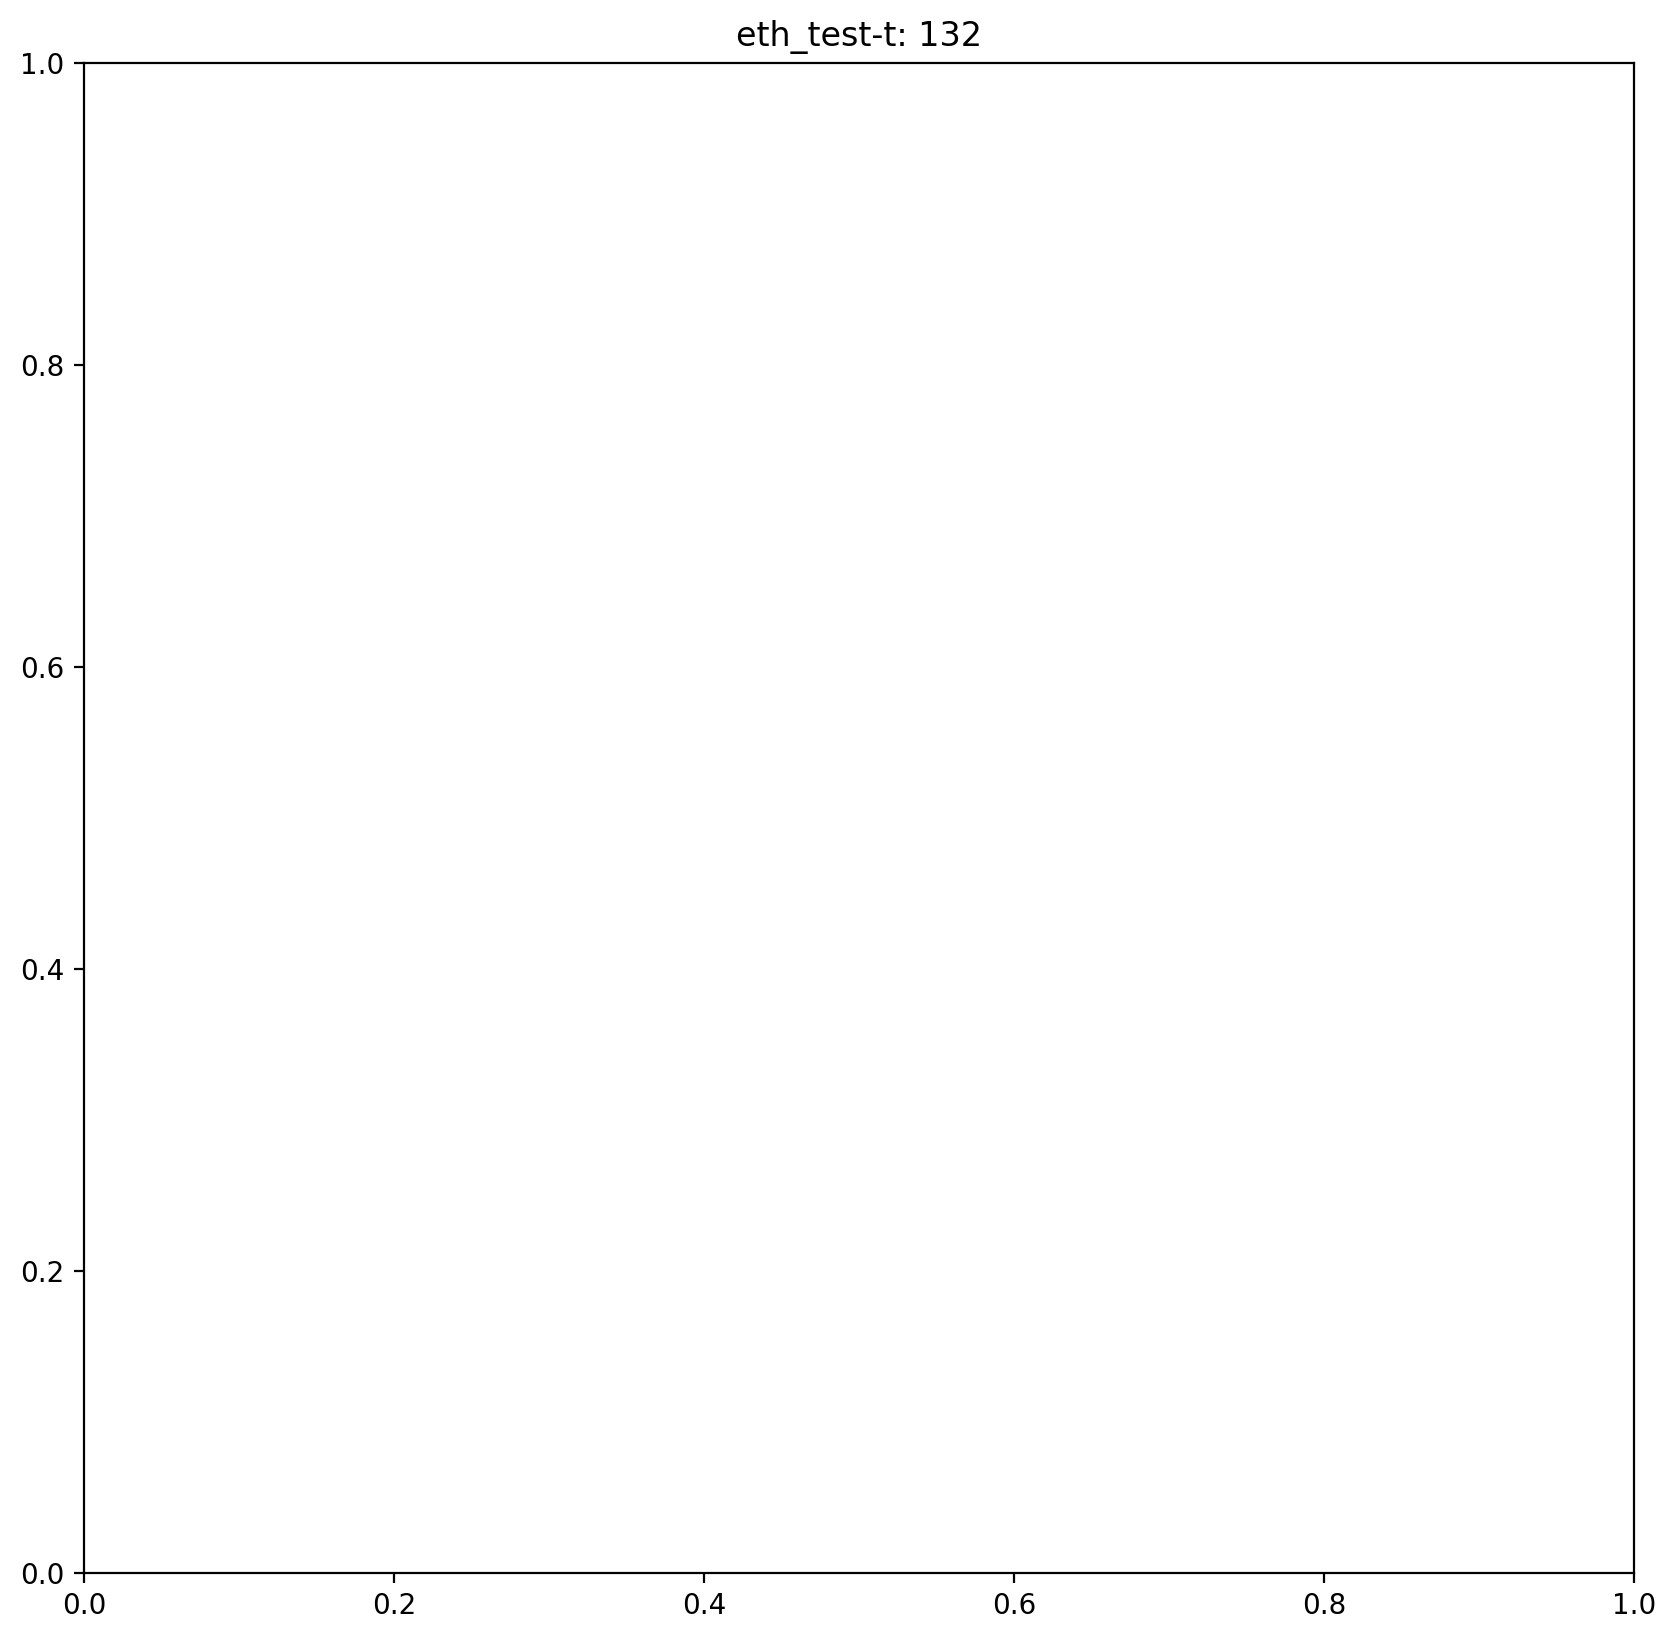

In [107]:
# Oletetaan, että eval_trajectron on luotu ja environment asetettu
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)

# Tee ennuste
predictions = eval_trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=1,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      gmm_mode=True,
                                      all_z_sep=False,
                                      full_dist=False)

# Visualisoi
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep[0]}")
plt.show()


Text(0.5, 1.0, 'eth_test-t: [1050]')

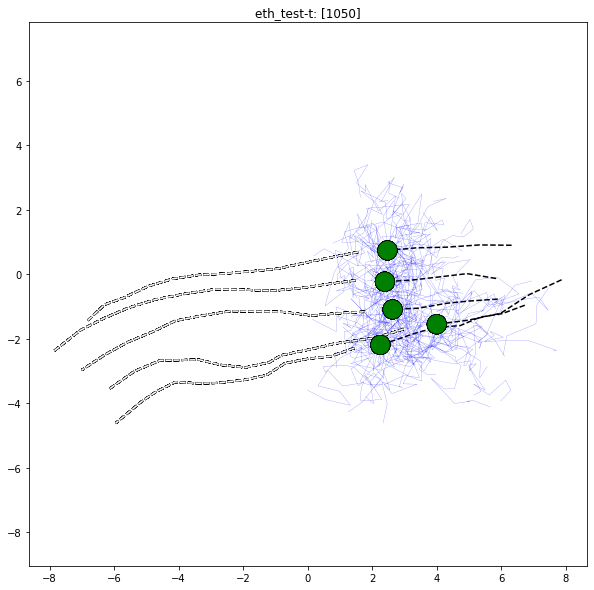

In [124]:
scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
timestep = scene.sample_timesteps(1, min_future_timesteps=ph)


predictions = trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=20,
                                      min_future_timesteps=ph,
                                      z_mode=False,
                                      full_dist=False)

# Plot predicted timestep for random scene
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep}")

Text(0.5, 1.0, 'eth_test-t: [394]')

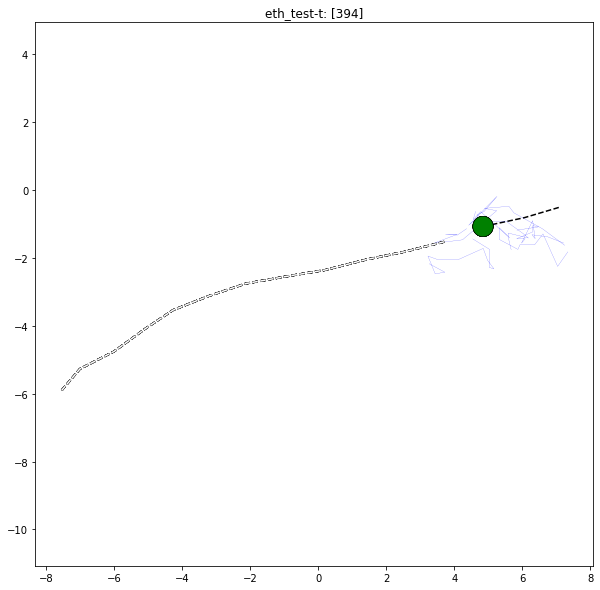

In [133]:
#scene = np.random.choice(env.scenes)  # ota satunnainen scene eval_env:stä
#timestep = scene.sample_timesteps(1, min_future_timesteps=ph)


predictions = trajectron.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples=5,
                                      min_future_timesteps=ph,
                                      z_mode=True,
                                      full_dist=False)

# Plot predicted timestep for random scene
fig, ax = plt.subplots(figsize=(10, 10))
visualization.visualize_prediction(ax,
                                   predictions,
                                   scene.dt,
                                   max_hl=max_hl,
                                   ph=ph,
                                   map=scene.map['VISUALIZATION'] if scene.map is not None else None)
ax.set_title(f"{scene.name}-t: {timestep}")

In [134]:
predictions = trajectron.predict(
    scene,
    timestep,
    ph,
    num_samples=1,       # Yksi sample riittää, koska piirrämme GMM:n
    min_future_timesteps=ph,
    z_mode=False,
    full_dist=True,      # Tärkeää GMM:n visualisointiin
    gmm_mode=True        # Tuo GMM:n parametrit (mus, covs, pis)
)

TypeError: arange() received an invalid combination of arguments - got (Tensor, Tensor, float), but expected one of:
 * (Number end, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Number start, Number end, Number step, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [129]:
from model.dataset import get_timesteps_data


In [110]:
empty_counts = 0
total_counts = 0

for scene in env.scenes:
    timesteps = np.arange(scene.timesteps)
    for t in timesteps:
        batch = get_timesteps_data(env=env, scene=scene, t=[t], node_type=list(eval_trajectron.pred_state.keys()),
                                   state=eval_trajectron.state,
                                   pred_state=eval_trajectron.pred_state,
                                   edge_types=None,  # tarvittaessa mallisi edge_types
                                   min_ht=eval_trajectron.min_ht,
                                   max_ht=eval_trajectron.max_ht,
                                   min_ft=ph,
                                   max_ft=ph,
                                   hyperparams=eval_trajectron.hyperparams)
        total_counts += 1
        if batch is None:
            empty_counts += 1

print(f"Timestepien määrä ilman ennustettavia nodeja: {empty_counts}/{total_counts}")


Timestepien määrä ilman ennustettavia nodeja: 1161/1161
